In [82]:
import sys
import os
import PIL
from PIL import Image,ImageFilter, ImageDraw
from math import *
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from matplotlib.patches import Ellipse
import tqdm as tq
from numpy.linalg import eig, inv
import scipy
from scipy import ndimage
from skimage import data, io, filters
from skimage import data, img_as_float
from skimage import exposure
import math
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import skimage

[71, 28]
[71, 28]
(28, 71, 4)


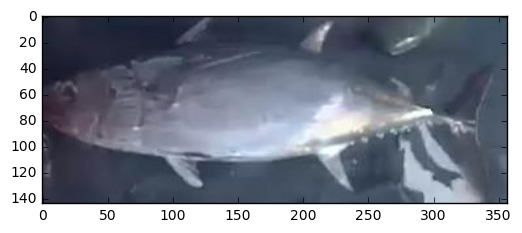

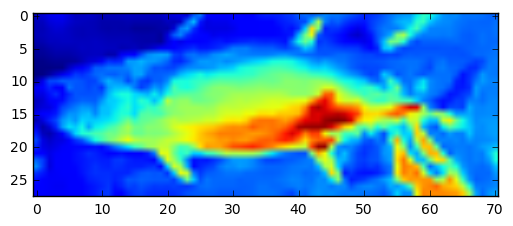

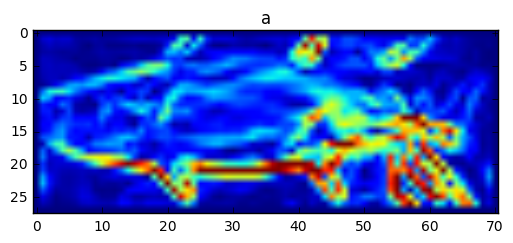

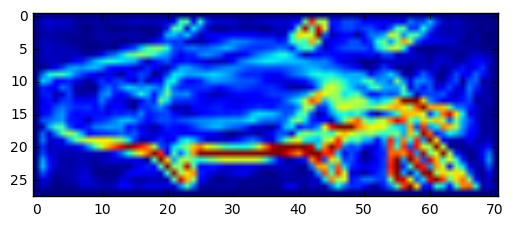

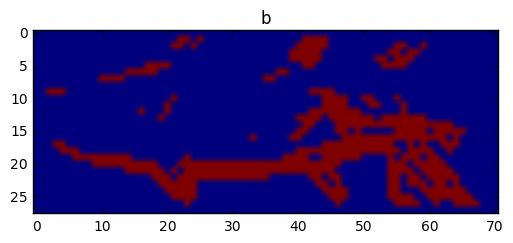

In [175]:
input_path = './cropped_train/ALB/'
files = os.listdir(input_path)
N = 51
M = 5
WH = 50
im = Image.open(input_path+files[N])

plt.figure(0)
plt.imshow(im)

size = np.array(im.size)/M
size = [int(i) for i in size]
print(size)
width,height = size
while width > WH and height > WH:
    size = np.array(im.size)/M
    size = [int(i) for i in size]
    width,height = size
    M+=1
print(size)
SIZE = size

im = im.resize(size, PIL.Image.ANTIALIAS)
io = Image.new('RGB',(width, height),(255,255,255))

plt.figure(1)
im = im.convert('L')
plt.imshow(im)

plt.figure(2)
edges = filters.scharr(im)
p2, p98 = np.percentile(edges, (2, 98))
img_rescale = exposure.rescale_intensity(edges, in_range=(p2, p98))

plt.imsave('data.png',img_rescale)
imsaved = Image.open('data.png')
plt.figure()
plt.title('a')
plt.imshow(imsaved)

mm = np.array(imsaved)
print(mm.shape)
plt.figure()
plt.imshow(mm)
mm[np.where(mm[:,:,0]!=0)]=255
mm[:,:,1]=0
mm[np.where(mm[:,:,1]!=0)]=255
mm[:,:,2]=0
mm = mm[:,:,0]
plt.figure()
plt.title('b')
plt.imshow(mm)
#mm[:,:,0]=0
plt.show()

In [169]:
pixels = Image.fromarray(mm)
THRESHOLD = 5
import itertools
def is_not_isolated(x,y):
    
    if x > 0 and y > 0 and x < SIZE[0]-1 and y < SIZE[1]-1:
        not_isolated = mm[x+1,y+1] == 255 or mm[x+1,y] == 255 or mm[x+1,y-1] == 255 or mm[x,y-1] == 255 or mm[x-1,y-1] == 255 or mm[x-1,y] == 255 or mm[x-1,y+1] == 255 or mm[x,y+1] == 255
        return  not_isolated
    else:
        return False

def has_n(x,y):
    if x > 0 and y > 0 and x < SIZE[0]-1 and y < SIZE[1]-1:
        vector_x = [x-1,x,x+1]
        vector_y = [y-1,y,y+1]  
        combi = list(itertools.product(vector_x, vector_y))
        count = 0
        for pos in combi:
            if mm[pos[0],pos[1]] == 255:
                count += 1
        if count >= THRESHOLD:
            return True
        else:
            return False
def has_n2(x,y):
    if x > 0 and y > 0 and x < SIZE[0]-1 and y < SIZE[1]-1:
        vector_x = [x-1,x,x+1]
        vector_y = [y-1,y,y+1]  
        combi = list(itertools.product(vector_x, vector_y))
        count = 0
        for pos in combi:
            if mm[pos[0],pos[1]] == 255:
                count += 1
        if count >= THRESHOLD:
            return False
        else:
            return True
        
def is_not_isolated2(x,y):  
    if x > 0 and y > 0 and x < SIZE[0]-1 and y < SIZE[1]-1:
        not_isolated = mm[x+1,y+1] == 255 or mm[x+1,y] == 255 or mm[x+1,y-1] == 255 or mm[x,y-1] == 255 or mm[x-1,y-1] == 255 or mm[x-1,y] == 255 or mm[x-1,y+1] == 255 or mm[x,y+1] == 255
        return  not not_isolated
    else:
        return True

pxy = []
for x in range(1,SIZE[1]-1):
    obj = []
    for y in range(1,SIZE[0]-1):
        if mm[x,y] == 255 and is_not_isolated2(x,y):#: and has_n2(x,y):
            obj.append(255)
        else:
            obj.append(0)
    pxy.append(obj)
pxy1 = []
for x in range(1,SIZE[1]-1):
    obj = []
    for y in range(1,SIZE[0]-1):
        if mm[x,y] == 255 and is_not_isolated(x,y):#: and has_n(x,y):
            obj.append(255)
        else:
            obj.append(0)
    pxy1.append(obj)    

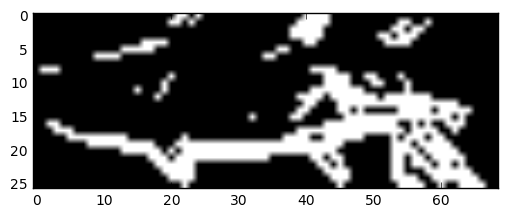

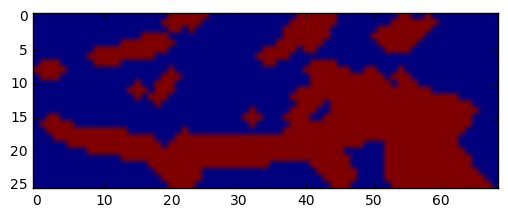

In [170]:
plt.figure(0)
image_1 = Image.fromarray(np.array(pxy)+np.array(pxy1))#.transpose(Image.FLIP_LEFT_RIGHT).rotate(90,expand=True)
plt.imshow(image_1)

plt.figure(1)
image_2 = ndimage.binary_dilation(image_1)
plt.imshow(image_2)
plt.show()

[[ 260.07008201    5.84129041]
 [   5.84129041   43.434413  ]]
(array([ 73.45531363,  41.2038835 ,   8.95245336]), array([ 16.3617037 ,  15.49271845,  14.62373319]))
0
[32.251430131692089, 0.86898525288418327]
[ 0.99963721  0.02693431]
1.543408890061294


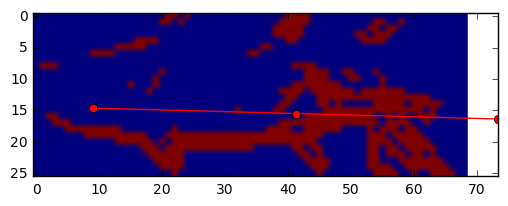

In [171]:
def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum()

def intertial_axis(data):
    """Calculate the x-mean, y-mean, and cov matrix of an image."""
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_bar = m10 / data_sum
    y_bar = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_bar * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_bar * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_bar * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return x_bar, y_bar, cov

def plot_bars(x_bar, y_bar, cov, ax):
    """Plot bars with a length of 2 stddev along the principal axes."""
    def make_lines(eigvals, eigvecs, mean, i):
        """Make lines a length of 2 stddev."""
        std = np.sqrt(eigvals[i])
        vec = 2 * std * eigvecs[:,i] / np.hypot(*eigvecs[:,i])
        x, y = np.vstack((mean-vec, mean, mean+vec)).T
        return x, y
    mean = np.array([x_bar, y_bar])
    eigvals, eigvecs = np.linalg.eigh(cov)
    #ax.plot(*make_lines(eigvals, eigvecs, mean, 0), marker='o', color='white')
    ax.plot(*make_lines(eigvals, eigvecs, mean, -1), marker='o', color='red')
    ax.axis('image')
    return  make_lines(eigvals, eigvecs, mean, -1),eigvecs
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

angle = 0 
size = SIZE
w,h = SIZE
data = np.array(image_1)
xbar, ybar, cov = intertial_axis(data)
print(cov)

fig, ax = plt.subplots()
ax.imshow(data)

gd_lines,eigvecs = plot_bars(xbar, ybar, cov, ax)
hori = np.array([1,0])

print(gd_lines)

ij = [0,2]
for i in ij:
    print(i)
    vector = [gd_lines[0][i]-gd_lines[0][1],gd_lines[1][i]-gd_lines[1][1]]
    print(vector)
    if vector[0] >= 0:
        break
vector = vector/LA.norm(vector)
print(vector)
angle = math.acos(np.dot(hori,vector))*(180/math.pi)
print(angle)
plt.show()

6.393194643773006


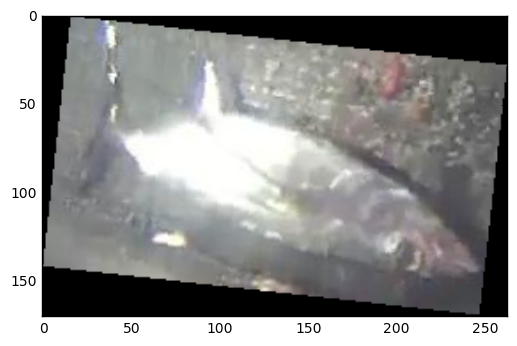

In [139]:
print(angle)
if angle < 0:
    angle = -angle
else:
    angle = 180-angle   

img = Image.open(input_path+files[N])
img3 = img.rotate(angle, expand=True)
plt.imshow(img3)
plt.show()

In [140]:
print(ABC)

NameError: name 'ABC' is not defined

In [ ]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()

ax2.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                     d[-1], d[0]],
             cmap=plt.cm.gray, aspect=1/1.5)
ax2.set_title('Hough transform')
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.axis('image')

ax3.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    ax3.plot((0, cols), (y0, y1), '-r')
ax3.axis((0, cols, rows, 0))
ax3.set_title('Detected lines')
ax3.set_axis_off()

# Line finding, using the Probabilistic Hough Transform

image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()
ax1.set_adjustable('box-forced')

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Canny edges')
ax2.set_axis_off()
ax2.set_adjustable('box-forced')

ax3.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    ax3.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax3.set_title('Probabilistic Hough')
ax3.set_axis_off()
ax3.set_adjustable('box-forced')
plt.show()